#Chicago Crime Data Analysis

This project is based on the data provided by City of Chicago on https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

According to the webpage, "this dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified".


In this project, I will analyze the crime data from two perspectives: tourisms and residents. At the end, we will have some suggestions for tourisms who plan to travel Chicago and some advice for future residents who are going to move to Chicago.


1. Is the number of crimes decreasing over year?
2. What are some common crimes in Chicago?
3. What are the places that crimes happen more frequently?
4. Is there any seasonalitiy within years for crimes?
5. Is there any seasonality whthin a day for crimes?
6. Are domtestic-related crimes more likely conducted?
7. Has the overall performance of the police in Chicago improved based on the arresting rate?
8. Which area has a better control of crime based on the number of incidents and arresting rate?
9. Which areas are recommended to live?
10. How has the crime changed due to COVID-19?



In [1]:
!pip install sodapy
from sodapy import Socrata
import pandas as pd
# Now, we will get the data from the website

client = Socrata("data.cityofchicago.org", None)
results = client.get("ijzp-q8t2", limit = 320000)
results_df = pd.DataFrame.from_records(results)

results_df


,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_rpca_8um6,:@computed_region_d9mm_jgwp,:@computed_region_d3ds_rm58
0,12296687,JE146533,2021-02-19T23:50:00.000,039XX N ELSTON AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,False,1732,017,35,16,08A,1151844,1925835,2021,2021-02-26T15:47:53.000,41.95236753,-87.717214999,"{'latitude': '41.95236753', 'longitude': '-87....",2,21538,16,325,12,39,1,20
1,12296719,JE146530,2021-02-19T23:50:00.000,112XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2233,022,34,49,08B,1175300,1830296,2021,2021-02-26T15:47:53.000,41.689704965,-87.633849701,"{'latitude': '41.689704965', 'longitude': '-87...",45,21861,45,486,22,19,9,258
2,12296725,JE146520,2021-02-19T23:43:00.000,012XX W 81ST ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0613,006,21,71,08B,1169518,1851073,2021,2021-02-26T15:47:53.000,41.746847069,-87.654417825,"{'latitude': '41.746847069', 'longitude': '-87...",18,21554,70,575,13,59,20,230
3,12296711,JE146524,2021-02-19T23:38:00.000,100XX S LA SALLE ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,True,0511,005,9,49,14,1177044,1838339,2021,2021-02-26T15:47:53.000,41.711737069,-87.627223513,"{'latitude': '41.711737069', 'longitude': '-87...",30,21861,45,569,43,19,10,250
4,12296676,JE146525,2021-02-19T23:38:00.000,008XX E 87TH PL,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,RESIDENCE - YARD (FRONT / BACK),True,False,0632,006,8,44,15,1183458,1847145,2021,2021-02-26T15:47:53.000,41.735755033,-87.603460555,"{'latitude': '41.735755033', 'longitude': '-87...",9,21546,40,429,35,61,20,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,11811216,JC411547,2019-08-29T03:50:00.000,076XX S EXCHANGE AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,GAS STATION,False,False,0421,004,7,43,04A,1195776,1855003,2019,2019-09-05T16:01:50.000,41.75702248,-87.558073456,"{'latitude': '41.75702248', 'longitude': '-87....",43,22538,39,245,37,24,19,225
319996,11811064,JC411553,2019-08-29T03:30:00.000,082XX S MUSKEGON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,0423,004,7,46,14,1196593,1850956,2019,2019-09-05T16:01:50.000,41.745896971,-87.555213485,"{'latitude': '41.745896971', 'longitude': '-87...",43,21202,42,244,37,25,19,238
319997,11811965,JC413764,2019-08-29T03:30:00.000,024XX W MOFFAT ST,0810,THEFT,OVER $500,RESIDENCE,False,False,1434,014,1,22,06,1159751,1912219,2019,2019-09-05T16:01:50.000,41.914844667,-87.688525036,"{'latitude': '41.914844667', 'longitude': '-87...",24,22535,23,180,41,1,7,192
319998,11810133,JC411533,2019-08-29T03:26:00.000,021XX N LONG AVE,0496,BATTERY,AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST,RESIDENCE,True,True,2515,025,36,19,04B,1140038,1913687,2019,2019-09-05T16:01:50.000,41.919256878,-87.760912869,"{'latitude': '41.919256878', 'longitude': '-87...",4,22615,19,307,44,2,6,133


#Data Exploration

In this stage, we will take a look at the data type and also get slices of data to see if they answer our questions.


In [2]:
results_df.sort_values(['date'], ascending= True)
results_df

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_rpca_8um6,:@computed_region_d9mm_jgwp,:@computed_region_d3ds_rm58
0,12296687,JE146533,2021-02-19T23:50:00.000,039XX N ELSTON AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,False,1732,017,35,16,08A,1151844,1925835,2021,2021-02-26T15:47:53.000,41.95236753,-87.717214999,"{'latitude': '41.95236753', 'longitude': '-87....",2,21538,16,325,12,39,1,20
1,12296719,JE146530,2021-02-19T23:50:00.000,112XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2233,022,34,49,08B,1175300,1830296,2021,2021-02-26T15:47:53.000,41.689704965,-87.633849701,"{'latitude': '41.689704965', 'longitude': '-87...",45,21861,45,486,22,19,9,258
2,12296725,JE146520,2021-02-19T23:43:00.000,012XX W 81ST ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0613,006,21,71,08B,1169518,1851073,2021,2021-02-26T15:47:53.000,41.746847069,-87.654417825,"{'latitude': '41.746847069', 'longitude': '-87...",18,21554,70,575,13,59,20,230
3,12296711,JE146524,2021-02-19T23:38:00.000,100XX S LA SALLE ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,True,0511,005,9,49,14,1177044,1838339,2021,2021-02-26T15:47:53.000,41.711737069,-87.627223513,"{'latitude': '41.711737069', 'longitude': '-87...",30,21861,45,569,43,19,10,250
4,12296676,JE146525,2021-02-19T23:38:00.000,008XX E 87TH PL,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,RESIDENCE - YARD (FRONT / BACK),True,False,0632,006,8,44,15,1183458,1847145,2021,2021-02-26T15:47:53.000,41.735755033,-87.603460555,"{'latitude': '41.735755033', 'longitude': '-87...",9,21546,40,429,35,61,20,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,11811216,JC411547,2019-08-29T03:50:00.000,076XX S EXCHANGE AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,GAS STATION,False,False,0421,004,7,43,04A,1195776,1855003,2019,2019-09-05T16:01:50.000,41.75702248,-87.558073456,"{'latitude': '41.75702248', 'longitude': '-87....",43,22538,39,245,37,24,19,225
319996,11811064,JC411553,2019-08-29T03:30:00.000,082XX S MUSKEGON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,0423,004,7,46,14,1196593,1850956,2019,2019-09-05T16:01:50.000,41.745896971,-87.555213485,"{'latitude': '41.745896971', 'longitude': '-87...",43,21202,42,244,37,25,19,238
319997,11811965,JC413764,2019-08-29T03:30:00.000,024XX W MOFFAT ST,0810,THEFT,OVER $500,RESIDENCE,False,False,1434,014,1,22,06,1159751,1912219,2019,2019-09-05T16:01:50.000,41.914844667,-87.688525036,"{'latitude': '41.914844667', 'longitude': '-87...",24,22535,23,180,41,1,7,192
319998,11810133,JC411533,2019-08-29T03:26:00.000,021XX N LONG AVE,0496,BATTERY,AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST,RESIDENCE,True,True,2515,025,36,19,04B,1140038,1913687,2019,2019-09-05T16:01:50.000,41.919256878,-87.760912869,"{'latitude': '41.919256878', 'longitude': '-87...",4,22615,19,307,44,2,6,133


In [3]:
# Since date is not in datetime type, we need to do some data cleansing.

results_df['date'] = pd.to_datetime(results_df['date'])

results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           320000 non-null  object        
 1   case_number                  320000 non-null  object        
 2   date                         320000 non-null  datetime64[ns]
 3   block                        320000 non-null  object        
 4   iucr                         320000 non-null  object        
 5   primary_type                 320000 non-null  object        
 6   description                  320000 non-null  object        
 7   location_description         318301 non-null  object        
 8   arrest                       320000 non-null  bool          
 9   domestic                     320000 non-null  bool          
 10  beat                         320000 non-null  object        
 11  district                  

#Data Analysis - Crime Types

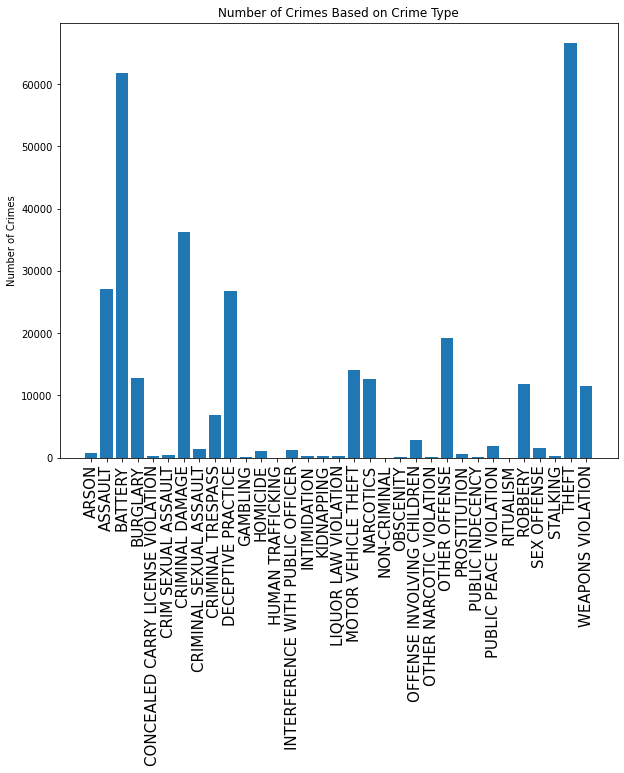

In [4]:
import matplotlib.pyplot as plt

# What are some common crimes in Chicago?
type1 = results_df[['id','primary_type']].copy()
type1 = type1.groupby('primary_type').count().copy()
type1.reset_index(inplace=True)

plt.figure(figsize=(10,8))
plt.bar(type1['primary_type'], type1['id'])
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Based on Crime Type')
plt.xticks(fontsize=15, rotation=90)
plt.show()

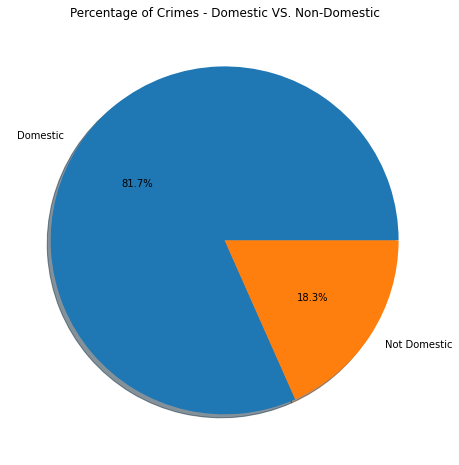

In [5]:
# Are domtestic-related crimes more likely conducted?
type2 = results_df[['id','domestic']].copy()
type2 = type2.groupby('domestic').count()

type2.reset_index(inplace=True)
type2['domestic'] = ['Domestic','Not Domestic']
plt.figure(figsize=(10,8))
plt.pie(type2['id'], labels = type2['domestic'], autopct='%1.1f%%', shadow=True)
plt.title('Percentage of Crimes - Domestic VS. Non-Domestic')
plt.show()

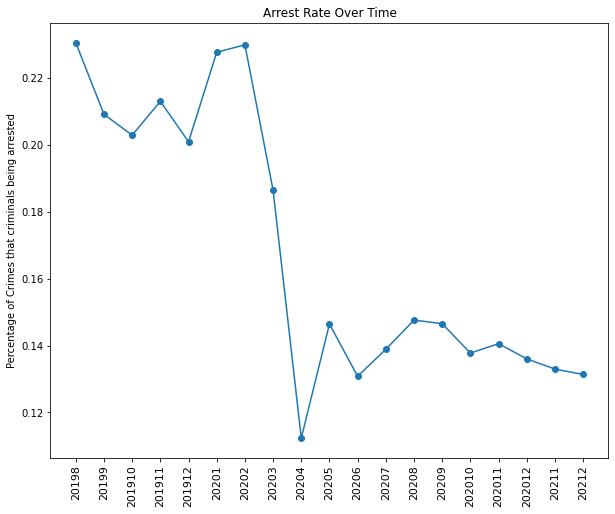

In [6]:
# Has the overall performance of the police in Chicago improved based on the arresting rate?
type3 = results_df[['date','arrest']].copy()

# Get the variables and organize into a new DataFrame
type3['year'] = pd.DatetimeIndex(type3['date']).year
type3['month'] = pd.DatetimeIndex(type3['date']).month
type3['YearMon'] = type3["year"].astype(str) +  type3["month"].astype(str)
type3['YearMon'].astype(int)

type3_true = type3[type3['arrest']==True]
true_count = type3_true.groupby(['YearMon']).count().copy()

type3_false = type3[type3['arrest']==False]
false_count = type3_false.groupby(['YearMon']).count().copy()

true_count['False'] = false_count['arrest']

type3_2 = true_count.copy()
type3_2['arate'] = type3_2['arrest']/(type3_2['arrest']+type3_2['False'])
type3_2 = type3_2[['arate']]

type3_2['YearMonth'] = type3_2.index.values

type3_2['YearMonth'] = pd.to_datetime(type3_2['YearMonth'], format = '%Y%m')
type3_2['YearMonth'] = type3_2['YearMonth'].dt.to_period('M')
type3_2.sort_values(by=['YearMonth'],inplace = True)

plt.figure(figsize=(10,8))
plt.plot(type3_2['arate'], marker = 'o')
plt.xticks(fontsize=11, rotation=90)
plt.ylabel('Percentage of Crimes that criminals being arrested')
plt.title('Arrest Rate Over Time')
plt.show()

#Data Analysis - Time


In [7]:
season = results_df[['id', 'date']].copy()

season['year'] = pd.DatetimeIndex(season['date']).year
season['month'] = pd.DatetimeIndex(season['date']).month
season['time'] = pd.DatetimeIndex(season['date']).hour
season = season[season['year']==2020]

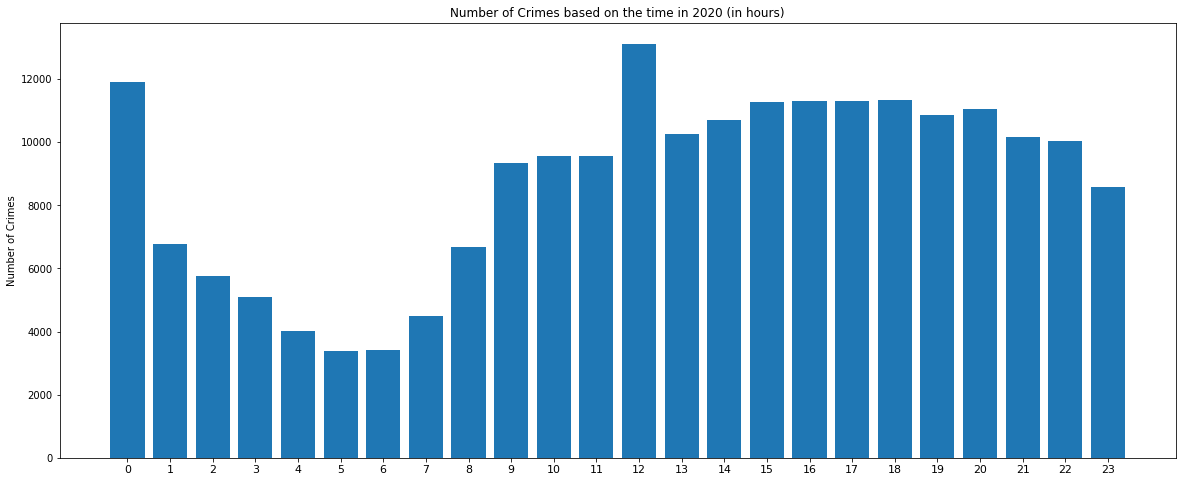

In [8]:
# What time of a day does it have a higher number of crimes?
season1 = season.groupby('time').count().copy()
season1.reset_index(inplace=True)
season1.set_index(season1['time'], inplace = True)

season1['id'] = season1['id'].astype(int)
season1['time'] =season1['time'].astype(str)


plt.figure(figsize=(20,8))
plt.bar(season1['time'], season1['id'])
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes based on the time in 2020 (in hours)')
plt.xticks(fontsize=11)
plt.show()

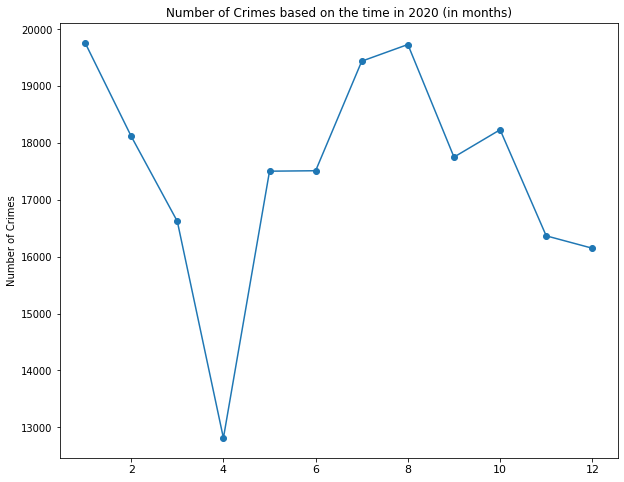

In [9]:
# Which months will there be more crimes?

season2 = season.groupby('month').count()

season2.reset_index(inplace = True)
season2.set_index(season2['month'], inplace=True)

plt.figure(figsize=(10,8))
plt.plot(season2['id'], marker = 'o')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes based on the time in 2020 (in months)')
plt.xticks(fontsize=11)
plt.show()

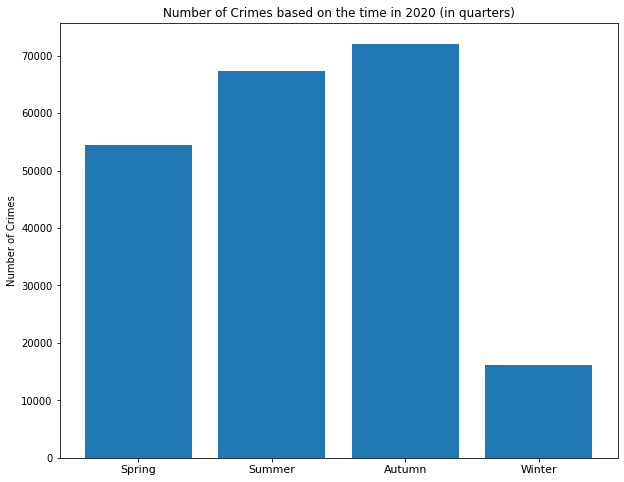

In [10]:
# Which quarters will there be more crimes?
season3 = season.copy()
season3['quarter'] = season3['month']//4+1

season3 = season3.groupby('quarter').count()

season3.reset_index(inplace = True)
season3.set_index(season3['quarter'], inplace=True)

plt.figure(figsize=(10,8))
plt.bar(season3['quarter'], season3['id'])
plt.xticks(ticks = [1,2,3,4], labels = ['Spring', 'Summer', 'Autumn', 'Winter'], fontsize=11)
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes based on the time in 2020 (in quarters)')
plt.show()

#Data Analysis - Area

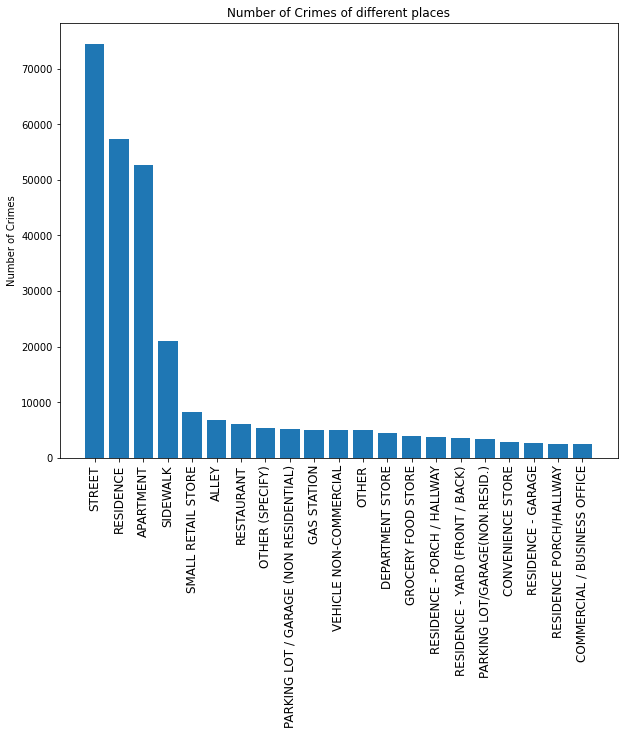

In [12]:
# What are the places that crimes happen more frequently?
area1 = results_df[['id','location_description']]

area1 = area1.groupby('location_description').count().copy()
area1.reset_index(inplace=True)
area1.sort_values(by=['id'], ascending = False, inplace = True)

area1_selected = area1[:21]

plt.figure(figsize=(10,8))
plt.bar(area1_selected['location_description'], area1_selected['id'])
plt.xticks(fontsize=12, rotation=90)
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes of different places')
plt.show()


In [13]:
# Which area has a better control of crime based on the number of incidents and arresting rate?
area2 = results_df[['id','community_area','arrest']].copy()
area2.dropna(inplace = True)
area2['community_area'] = area2['community_area'].astype(int)


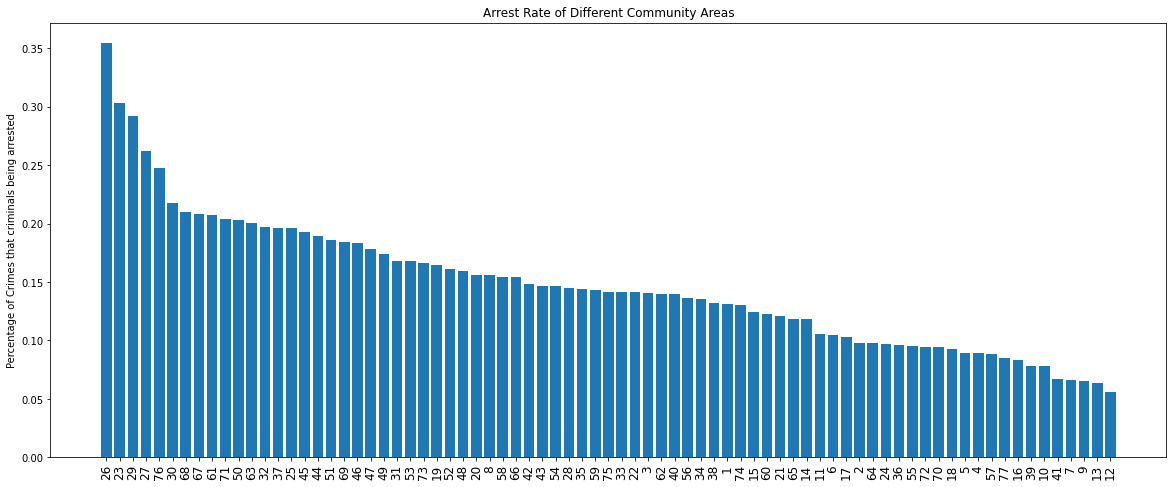

In [14]:
area2_true = area2[area2['arrest']==True]
true_count2 = area2_true.groupby(['community_area']).count().copy()

area2_false = area2[area2['arrest']==False]
false_count2 = area2_false.groupby(['community_area']).count().copy()

true_count2['False'] = false_count2['arrest']

area2_2 = true_count2.copy()
area2_2['arate'] = area2_2['arrest']/(area2_2['arrest']+area2_2['False'])
area2_2 = area2_2[['arate']]

area2_2.reset_index(inplace = True)
area2_2.sort_values(by= ['arate'], ascending = False, inplace = True)
area2_2['community_area'] = area2_2['community_area'].astype(str)

plt.figure(figsize=(20,8))
plt.bar(area2_2['community_area'], area2_2['arate'])
plt.xticks(fontsize=12, rotation=90)
plt.ylabel('Percentage of Crimes that criminals being arrested')
plt.title('Arrest Rate of Different Community Areas')
plt.show()

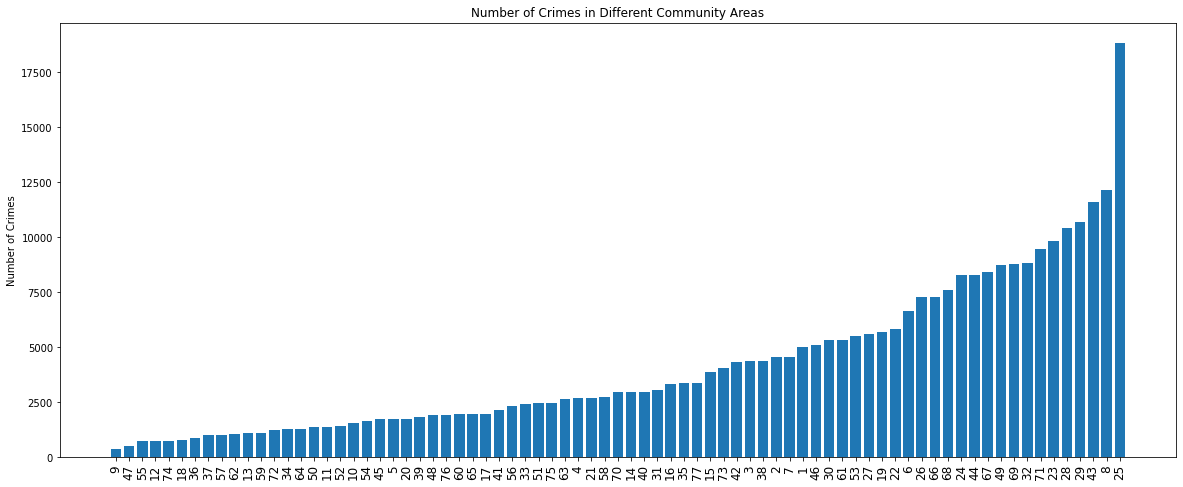

In [15]:
area2_3 = area2.groupby('community_area').count()

area2_3.reset_index(inplace=True)
area2_3.set_index(area2_3['community_area'],inplace=True)

area2_3.sort_values(by=['id'], inplace = True)
area2_3['community_area'] = area2_3['community_area'].astype(str)

plt.figure(figsize=(20,8))
plt.bar(area2_3['community_area'], area2_3['id'])
plt.xticks(fontsize=12, rotation=90)
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes in Different Community Areas')
plt.show()

#Data Analysis - Additional

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


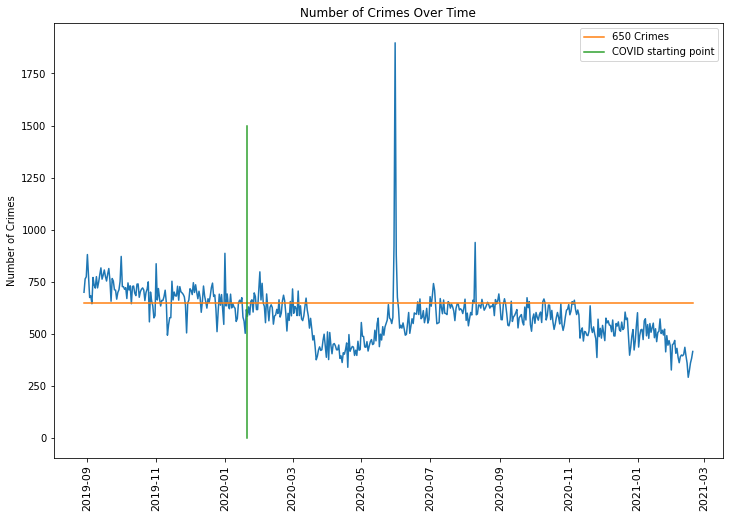

In [16]:
# Here is last question. How has the crime changed due to COVID-19?
import datetime

extra = results_df[['date']]
extra['time'] = pd.DatetimeIndex(extra['date']).date
extra = extra.groupby('time').count()

extra = extra.reset_index()
extra.columns = ['date','count']

extra['date'].astype(str)
extra.set_index(extra['date'], inplace = True)


plt.figure(figsize=(12,8))
plt.plot(extra['count'])
plt.xticks(fontsize=11, rotation=90)
plt.plot([extra.iloc[0,0],extra.iloc[-1,0]],[650,650], label = '650 Crimes')
plt.plot([datetime.date(2020, 1, 21),datetime.date(2020, 1, 21)],[0,1500], label = 'COVID starting point')
plt.legend()
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Over Time')
plt.show()